In [1]:
import numpy as np
from pycalphad import Database, Model, variables as v
from pycalphad.tests.datasets import ALFE_TDB

dbf = Database(ALFE_TDB)
mod_liq = Model(dbf, ['AL', 'FE'], 'LIQUID')
#save = mod_liq.models['idmix']
#mod_liq.models.clear()
#mod_liq.models['idmix'] = save
mod_alfe = Model(dbf, ['AL', 'FE', 'VA'], 'AL13FE4')

In [2]:
from pycalphad.core.problem import Problem
from pycalphad.core.composition_set import CompositionSet
from pycalphad.codegen.callables import build_phase_records

conds = {v.N: 1, v.P: 1e5, v.T: 300, v.X('AL'): 0.8}
comps = [v.Species('AL'), v.Species('FE'), v.Species('VA')]

prx = build_phase_records(dbf, comps, ['LIQUID', 'AL13FE4'], conds,
                         models={'LIQUID': mod_liq, 'AL13FE4': mod_alfe}, build_gradients=True, build_hessians=True)
cs_liq = CompositionSet(prx['LIQUID'])
cs_alfe = CompositionSet(prx['AL13FE4'])
#cs_liq.update(np.array([1.00000000e+00,3.67650217e-13, 1.00000000e+00]), 1.48962701e-01,
#              np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02]), True)
#cs_alfe.update(np.array([1.00000000e+00, 1.00000000e+00, 9.99773278e-01, 2.26721529e-04]), 8.51037299e-01,
#               np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02]), True)
prob = Problem([cs_liq, cs_alfe], comps, {str(key): value for key, value in conds.items()})

In [3]:
x = [1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
       6.52975359e-13, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.99773278e-01, 2.26721528e-04, 1.48962701e-01, 8.51037299e-01]
x_exact = [1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
           3.67650217e-13, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           9.99773278e-01, 2.26721529e-04, 1.48962701e-01, 8.51037299e-01]
x = x_exact

In [4]:
from pycalphad import equilibrium, variables as v
equilibrium(dbf, ['AL', 'FE', 'VA'], ['AL13FE4', 'LIQUID'], {v.P: 1e5, v.T: 300, v.X('AL'): 0.8}).MU

<xarray.DataArray 'MU' (N: 1, P: 1, T: 1, X_AL: 1, component: 2)>
array([[[[[  -1037.66357753, -147371.6074997 ]]]]])
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1e+05
  * T          (T) float64 300.0
  * X_AL       (X_AL) float64 0.8
  * component  (component) <U2 'AL' 'FE'

In [42]:
import numpy as np
num_statevars = 3
num_components = 2
#chemical_potentials = np.array([-8490.140, -123111.773])
chemical_potentials = np.array([-50777.23348576, 2050.96387605])
phase_amt = np.array([1.0, 1e-10])
#phase_amt = np.array([1.0])
dof = [None, None]
# Exact solution
#dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00, 6.52975359e-13])
#dof[1] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
#                   1.00000000e+00, 9.99773278e-01, 2.26721529e-04])
# Tests
#dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 0.3, 0.7])
#dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 0.5, 0.5])
#dof[1] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
#                   1.00000000e+00, 9.99773278e-01, 2.26721529e-04])
dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.50000000e+02, 0.6, 0.4])
dof[1] = np.array([1.00000000e+00, 1.00000000e+05, 3.50000000e+02, 1.00000000e+00,
                   1.00000000e+00, 9.99773278e-01, 2.26721529e-04])

free_chemical_potential_indices = np.array([0,1])
fixed_chemical_potential_indices = np.array([])
free_stable_compset_indices = np.array([0])
free_statevar_indices = np.array([2])

delta_statevars = np.zeros(num_statevars)
for iteration in range(20):
    # FIRST STEP: Update potentials and phase amounts, according to conditions
    num_stable_phases = 2
    num_free_variables = free_chemical_potential_indices.shape[0] + free_stable_compset_indices.shape[0] + free_statevar_indices.shape[0]
    equilibrium_matrix = np.zeros((num_stable_phases + num_components, num_free_variables))
    equilibrium_rhs = np.zeros(num_stable_phases + num_components)
    if (num_stable_phases + num_components) != num_free_variables:
        raise ValueError('Conditions do not obey Gibbs Phase Rule')
    for idx, compset in enumerate((cs_liq, cs_alfe)):
        # TODO: Use better dof storage
        # Calculate key phase quantities starting here
        x = dof[idx]
        #print('x', x)
        energy_tmp = np.zeros((1,1))
        compset.phase_record.obj(energy_tmp[:,0], x)
        masses_tmp = np.zeros((num_components,1))
        mass_jac_tmp = np.zeros((num_components, num_statevars + compset.phase_record.phase_dof))
        for comp_idx in range(num_components):
            compset.phase_record.mass_grad(mass_jac_tmp[comp_idx, :], x, comp_idx)
            compset.phase_record.mass_obj(masses_tmp[comp_idx, :], x, comp_idx)
        # Compute phase matrix (LHS of Eq. 41, Sundman 2015)
        phase_matrix = np.zeros((compset.phase_record.phase_dof + compset.phase_record.num_internal_cons,
                                 compset.phase_record.phase_dof + compset.phase_record.num_internal_cons))
        hess_tmp = np.zeros((num_statevars + compset.phase_record.phase_dof,
                            num_statevars + compset.phase_record.phase_dof))
        cons_jac_tmp = np.zeros((compset.phase_record.num_internal_cons,
                                 num_statevars + compset.phase_record.phase_dof))
        compset.phase_record.hess(hess_tmp, x)
        grad_tmp = np.zeros(num_statevars + compset.phase_record.phase_dof)
        compset.phase_record.grad(grad_tmp, x)
        phase_matrix[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof] = hess_tmp[num_statevars:, num_statevars:]
        compset.phase_record.internal_cons_jac(cons_jac_tmp, x)
        phase_matrix[compset.phase_record.phase_dof:, :compset.phase_record.phase_dof] = cons_jac_tmp[:, num_statevars:]
        phase_matrix[:compset.phase_record.phase_dof, compset.phase_record.phase_dof:] = cons_jac_tmp[:, num_statevars:].T
        e_matrix = np.linalg.inv(phase_matrix)[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof]
        # Eq. 44
        c_G = -np.dot(e_matrix, grad_tmp[num_statevars:])
        c_statevars = -np.dot(e_matrix, hess_tmp[num_statevars:,:num_statevars])
        c_component = np.dot(mass_jac_tmp[:, num_statevars:], e_matrix)
        # Calculations of key quantities complete

        # KEY STEPS for filling equilibrium matrix
        # 1. Contribute to the row corresponding to this composition set
        # 1a. Loop through potential conditions to fill out each column
        # 2. Contribute to the row of all components
        # 2a. Loop through potential conditions to fill out each column
        # 3. Contribute to RHS of each component row
        # 4. Add energies to RHS of each stable composition set
        # 5. Subtract contribution from RHS due to any fixed chemical potentials
        # 6. Subtract fixed chemical potentials from each component RHS

        # 1a. This phase row: free chemical potentials
        free_variable_column_offset = 0
        for i in range(free_chemical_potential_indices.shape[0]):
            chempot_idx = free_chemical_potential_indices[i]
            equilibrium_matrix[idx, free_variable_column_offset+i] = masses_tmp[chempot_idx, 0]
        free_variable_column_offset += free_chemical_potential_indices.shape[0]
        # 1a. This phase row: free stable composition sets = zero contribution
        free_variable_column_offset += free_stable_compset_indices.shape[0]
        # 1a. This phase row: free state variables
        for i in range(free_statevar_indices.shape[0]):
            statevar_idx = free_statevar_indices[i]
            equilibrium_matrix[idx, free_variable_column_offset+i] = -grad_tmp[statevar_idx]
        # 2. Contribute to the row of all components
        component_row_offset = num_stable_phases
        for component_idx in range(num_components):
            free_variable_column_offset = 0
            # 2a. This component row: free chemical potentials
            for i in range(free_chemical_potential_indices.shape[0]):
                chempot_idx = free_chemical_potential_indices[i]
                equilibrium_matrix[component_row_offset+component_idx, free_variable_column_offset+i] += \
                    phase_amt[idx] * np.dot(mass_jac_tmp[component_idx, num_statevars:], c_component[chempot_idx, :])
            free_variable_column_offset += free_chemical_potential_indices.shape[0]
            # 2a. This component row: free stable composition sets
            for i in range(free_stable_compset_indices.shape[0]):
                compset_idx = free_stable_compset_indices[i]
                # Only fill this out if the current idx is equal to a free composition set
                if compset_idx == idx:
                    equilibrium_matrix[component_row_offset+component_idx, free_variable_column_offset+i] = masses_tmp[component_idx, 0]
            free_variable_column_offset += free_stable_compset_indices.shape[0]
            # 2a. This component row: free state variables
            for i in range(free_statevar_indices.shape[0]):
                statevar_idx = free_statevar_indices[i]
                equilibrium_matrix[component_row_offset+component_idx, free_variable_column_offset+i] += \
                    -phase_amt[idx] * np.dot(mass_jac_tmp[component_idx, num_statevars:], c_statevars[:, statevar_idx])
            # 3.
            equilibrium_rhs[component_row_offset+component_idx] += phase_amt[idx] * np.dot(mass_jac_tmp[component_idx, num_statevars:], -c_G)
        # 4.
        equilibrium_rhs[idx] = energy_tmp[0,0]
        # 5. Subtract fixed chemical potentials from each phase RHS
        for i in range(fixed_chemical_potential_indices.shape[0]): 
            chempot_idx = fixed_chemical_potential_indices[i]
            equilibrium_rhs[idx] -= masses_tmp[chempot_idx, :] * chemical_potentials[chempot_idx]
            # 6. Subtract fixed chemical potentials from each component RHS
            for component_idx in range(num_components):
                equilibrium_rhs[component_row_offset+component_idx] -= phase_amt[idx] * chemical_potentials[chempot_idx] * np.dot(mass_jac_tmp[component_idx, num_statevars:], c_component[chempot_idx, :])
    print('equilibrium_matrix', equilibrium_matrix)
    print('equilibrium_rhs', equilibrium_rhs)
    equilibrium_soln = np.linalg.solve(equilibrium_matrix, equilibrium_rhs)
    print('equilibrium_soln', equilibrium_soln)
    soln_index_offset = 0
    for i in range(free_chemical_potential_indices.shape[0]):
        chempot_idx = free_chemical_potential_indices[i]
        chemical_potentials[chempot_idx] = equilibrium_soln[soln_index_offset+i]
    soln_index_offset += free_chemical_potential_indices.shape[0]
    for i in range(free_stable_compset_indices.shape[0]):
        compset_idx = free_stable_compset_indices[i]
        phase_amt[compset_idx] += equilibrium_soln[soln_index_offset+i]
    soln_index_offset += free_stable_compset_indices.shape[0]
    delta_statevars[:] = 0
    for i in range(free_statevar_indices.shape[0]):
        statevar_idx = free_statevar_indices[i]
        delta_statevars[statevar_idx] = equilibrium_soln[soln_index_offset+i]
    for idx in range(len(dof)):
        dof[idx][:num_statevars] += delta_statevars
    print('NP', phase_amt, 'MU', chemical_potentials, 'statevars', dof[0][:num_statevars])
    true_delta_y = [None, None]
    # SECOND STEP: Update phase internal degrees of freedom
    for idx, compset in enumerate((cs_liq, cs_alfe)):
        # TODO: Use better dof storage
        x = dof[idx]
        # Compute phase matrix (LHS of Eq. 41, Sundman 2015)
        phase_matrix = np.zeros((compset.phase_record.phase_dof + compset.phase_record.num_internal_cons,
                                 compset.phase_record.phase_dof + compset.phase_record.num_internal_cons))
        hess_tmp = np.zeros((num_statevars + compset.phase_record.phase_dof,
                            num_statevars + compset.phase_record.phase_dof))
        cons_jac_tmp = np.zeros((compset.phase_record.num_internal_cons,
                                 num_statevars + compset.phase_record.phase_dof))
        compset.phase_record.hess(hess_tmp, x)
        phase_matrix[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof] = hess_tmp[num_statevars:, num_statevars:]
        compset.phase_record.internal_cons_jac(cons_jac_tmp, x)
        phase_matrix[compset.phase_record.phase_dof:, :compset.phase_record.phase_dof] = cons_jac_tmp[:, num_statevars:]
        phase_matrix[:compset.phase_record.phase_dof, compset.phase_record.phase_dof:] = cons_jac_tmp[:, num_statevars:].T

        # Compute right-hand side of Eq. 41, Sundman 2015
        rhs = np.zeros(compset.phase_record.phase_dof + compset.phase_record.num_internal_cons)
        grad_tmp = np.zeros(num_statevars + compset.phase_record.phase_dof)
        compset.phase_record.grad(grad_tmp, x)
        rhs[:compset.phase_record.phase_dof] = -grad_tmp[num_statevars:]
        rhs[:compset.phase_record.phase_dof] -= np.dot(hess_tmp[num_statevars:,:num_statevars], delta_statevars)
        mass_jac_tmp = np.zeros((num_components, num_statevars + compset.phase_record.phase_dof))
        for comp_idx in range(num_components):
            compset.phase_record.mass_grad(mass_jac_tmp[comp_idx, :], x, comp_idx)
        # Q: Do I need to multiply the mass gradient by the phase_amt?
        rhs[:compset.phase_record.phase_dof] += mass_jac_tmp.T.dot(chemical_potentials)[num_statevars:]
        soln = np.linalg.solve(phase_matrix, rhs)
        delta_y = soln[:compset.phase_record.phase_dof]
        old_y = np.array(x[num_statevars:])
        new_y = old_y + delta_y
        new_y[new_y < 1e-15] = 1e-15
        new_y[new_y > 1] = 1
        x[num_statevars:] = new_y
        true_delta_y[idx] = new_y - old_y
        print(compset.phase_record.phase_name, idx, true_delta_y[idx], new_y)


equilibrium_matrix [[ 6.00000000e-01  4.00000000e-01  0.00000000e+00  4.54783185e+01]
 [ 7.64992674e-01  2.35007326e-01  0.00000000e+00  2.68442751e+01]
 [ 5.38990170e-06 -5.38990170e-06  6.00000000e-01  2.37227376e-05]
 [-5.38990170e-06  5.38990170e-06  4.00000000e-01 -2.37227376e-05]]
equilibrium_rhs [-2.18982458e+04 -3.66757275e+04  3.91693627e-02 -3.91693627e-02]
equilibrium_soln [-5.79739733e+04 -6.16090689e+04 -1.13812046e-16  8.25223248e+02]
NP [1.e+00 1.e-10] MU [-57973.9732793  -61609.06892208] statevars [1.00000000e+00 1.00000000e+05 1.17522325e+03]
LIQUID 0 [-0.06860186  0.06860186] [0.53139814 0.46860186]
AL13FE4 1 [ 0.          0.         -0.00319924  0.00319924] [1.         1.         0.99657404 0.00342596]
equilibrium_matrix [[ 5.31398139e-01  4.68601861e-01  0.00000000e+00  8.08418460e+01]
 [ 7.64889246e-01  2.35110754e-01  0.00000000e+00  6.21213500e+01]
 [ 5.83456749e-06 -5.83456749e-06  5.31398139e-01  3.60639155e-05]
 [-5.83456749e-06  5.83456749e-06  4.68601861e-01

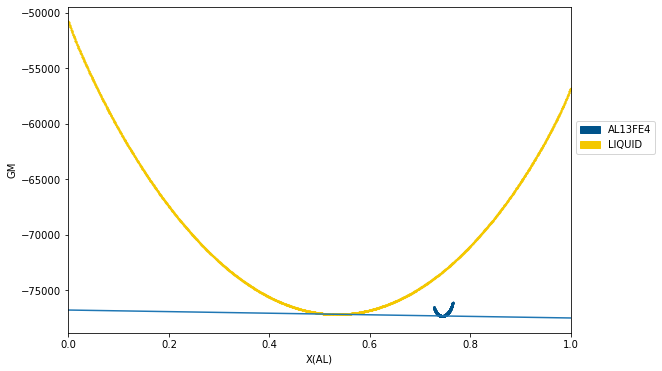

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, calculate, variables as v
from pycalphad.plot.utils import phase_legend
import numpy as np

# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(['AL13FE4', 'LIQUID'])

fig = plt.figure(figsize=(9,6))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(RE)
for phase_name in ['AL13FE4', 'LIQUID']:
    result = calculate(dbf, ['AL', 'FE', 'VA'], phase_name, P=101325, T=dof[0][2], output='GM', model={'LIQUID': mod_liq})
    ax.scatter(result.X.sel(component='AL'), result.GM, marker='.', s=2, color=color_dict[phase_name])
plt.plot([1,0], chemical_potentials)
# Format the plot
ax.set_xlabel('X(AL)')
ax.set_ylabel('GM')
ax.set_xlim((0, 1))
#ax.set_ylim((-50000, 10000))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()